In [ ]:
## Code has some reference from CS3244 Project 1 Group 3(Previous Project's Decision Tree Code) and adapted accordingly
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import all required libraries
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, average_precision_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import joblib

In [ ]:
##Used to merge the 2 small transcaction files HI-Small_Trans.csv and LI-Small_Trans.csv initially

#path='/content/drive/My Drive/CS3244 Project 2/HI-Small_Trans.csv'
#path='/content/drive/My Drive/CS3244 Project 2/LI-Small_Trans.csv'
##df = pd.read_csv(path)
#df2 = pd.read_csv(path2)
#df = pd.concat([df,df2])
#del df2
#df.to_csv('merge_Small_Trans.csv') 

In [ ]:
#Read the merged files from Google Drive
path='/content/drive/My Drive/CS3244 Project 2/merge_Small_Trans.csv'
df = pd.read_csv(path)
df

,Unnamed: 0,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0.0
1,1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0.0
2,2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0.0
3,3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0.0
4,4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1101964,1101964,2022/09/01 23:36,14433,80B7F36E0,16788,80BC02720,27.30,US Dollar,27.30,US Dollar,Credit Card,0.0
1101965,1101965,2022/09/01 23:57,20226,80BC05A90,20226,80BC05A90,352356.09,US Dollar,352356.09,US Dollar,Reinvestment,0.0
1101966,1101966,2022/09/01 23:37,22828,80BC11420,22828,80BC11420,27965.98,US Dollar,27965.98,US Dollar,Reinvestment,0.0
1101967,1101967,2022/09/01 23:58,15040,80BBFEFF0,15040,80BBFEFF0,26314.05,US Dollar,26314.05,US Dollar,Reinvestment,0.0


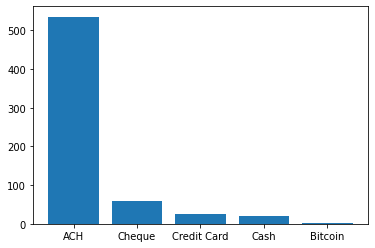

In [ ]:
#Doing a preliminary analysis of the distribution of the Receiving Currency
counts = df.loc[df['Is Laundering'] == 1,'Payment Format'].value_counts()
#plt.xticks(rotation=90)
plt.bar(counts.index, counts.values)
weights = {0 : (counts[0]/len(df))*100, 1 : (counts[1]/len(df))*100}
names = list(weights.keys())
values = list(weights.values())
plt.savefig("Distribution of Payment Format among all Money Laundering Cases.png",dpi=300)


In [ ]:
#Last row has na input for amount paid(Only removeds 1 row)
df = df.dropna(axis=0)

#Select the columns used for DT 
df = df[["Amount Received","Receiving Currency","Amount Paid","Payment Currency","Payment Format","Is Laundering"]]

#Preprocess the 3 columns that are required to be ont hot-coded
to_encode = ["Receiving Currency","Payment Currency","Payment Format"]
lab = preprocessing.OneHotEncoder()
for i in to_encode:
  data = lab.fit_transform(df[[i]]).toarray()   
  temp = pd.DataFrame(data,columns=lab.categories_[0]).add_prefix(i+"_")
  df = pd.concat([df, temp], axis=1)
  df = df.drop(i,axis=1)


df.dtypes

Amount Received                         float64
Amount Paid                             float64
Is Laundering                           float64
Receiving Currency_Australian Dollar    float64
Receiving Currency_Bitcoin              float64
Receiving Currency_Brazil Real          float64
Receiving Currency_Canadian Dollar      float64
Receiving Currency_Euro                 float64
Receiving Currency_Mexican Peso         float64
Receiving Currency_Ruble                float64
Receiving Currency_Rupee                float64
Receiving Currency_Saudi Riyal          float64
Receiving Currency_Shekel               float64
Receiving Currency_Swiss Franc          float64
Receiving Currency_UK Pound             float64
Receiving Currency_US Dollar            float64
Receiving Currency_Yen                  float64
Receiving Currency_Yuan                 float64
Payment Currency_Australian Dollar      float64
Payment Currency_Bitcoin                float64
Payment Currency_Brazil Real            

In [ ]:
#Split the dataframe into input vectors and output vectors
x, y = df.loc[:,df.columns != 'Is Laundering'], df.loc[:,'Is Laundering']
x 



,Amount Received,Amount Paid,Receiving Currency_Australian Dollar,Receiving Currency_Bitcoin,Receiving Currency_Brazil Real,Receiving Currency_Canadian Dollar,Receiving Currency_Euro,Receiving Currency_Mexican Peso,Receiving Currency_Ruble,Receiving Currency_Rupee,...,Payment Currency_US Dollar,Payment Currency_Yen,Payment Currency_Yuan,Payment Format_ACH,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire
0,3697.34,3697.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,14675.57,14675.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2806.97,2806.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,36682.97,36682.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101963,38.04,38.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1101964,27.30,27.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1101965,352356.09,352356.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1101966,27965.98,27965.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
y


0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1101963    0.0
1101964    0.0
1101965    0.0
1101966    0.0
1101967    0.0
Name: Is Laundering, Length: 1101968, dtype: float64

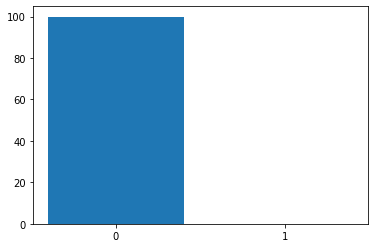

<Figure size 432x288 with 0 Axes>

In [ ]:
#Doing a preliminary analysis of the distribution of the dataset labels
counts = y.value_counts()
weights = {0 : (counts[0]/len(df))*100, 1 : (counts[1]/len(df))*100}

names = list(weights.keys())
values = list(weights.values())

#Plot the distribution of the labels
plt.bar(range(len(weights)), values, tick_label=names)
plt.show()
plt.savefig('Distribution of Money Laundering Labels.jpeg',format='jpeg',bbox_inches = "tight",dpi=1000)

In [ ]:
##Train-Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=13)
# example of random undersampling to balance the class distribution

##Create Undersampler to deal with the lack of data in label 1 and conduct undersampling
rus = RandomUnderSampler(random_state=13)

##Resample training and test dataset respectively to prevent Data Leakage
X_trainval, y_trainval = rus.fit_resample(X_trainval, y_trainval)
X_test, y_test = rus.fit_resample(X_test, y_test)

##Create Stratified k-fold for GridSearchCV
skf = StratifiedKFold(n_splits=10, shuffle= True, random_state=13)

In [ ]:
##Input the parameters to tune and direct into GridSearchCV
min_sam_split = range(2,20)
information_criterion = ["gini","entropy","log_loss"]
tree_d = range(1,30)
class_w = ["balanced",None]
param_g = {"min_samples_split":min_sam_split,
           "criterion":information_criterion,
           "max_depth":tree_d,
           "class_weight":class_w}
scoring = make_scorer(average_precision_score)


In [ ]:
#Create a DecisionTreeClassfier and optimize the hyperparameters with GridSearchCV - auprc
dt = DecisionTreeClassifier(random_state=13)
dt_model_auprc = GridSearchCV(dt,param_grid=param_g, cv=skf, refit=True,scoring=scoring,verbose=1).fit(X_trainval, y_trainval)

Fitting 10 folds for each of 3132 candidates, totalling 31320 fits


In [ ]:
#Print out relevant optimized hyperparameter values and its relevant statistics - auprc
'The optimal hyperparameters chosen are ' + str(dt_model_auprc.best_params_)

"The optimal hyperparameters chosen are {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2}"

In [ ]:
"The best AUPRC results over the training/validation dataset using 10-fold CV is " + str(dt_model_auprc.best_score_)

'The best AUPRC results over the training/validation dataset using 10-fold CV is 0.8593127108908825'

In [ ]:
"The best AUPRC results over the test dataset is " + str(dt_model_auprc.score(X_test, y_test))

'The best AUPRC results over the test dataset is 0.8839488636363636'

In [ ]:
data = {'Optimal Hyperparemater':str(dt_model_auprc.best_params_), 'Best AUPRC Results over the Training/Validation dataset':dt_model_auprc.best_score_ ,'Best AUPRC Results over the Test dataset':dt_model_auprc.score(X_test, y_test)}
  
# Creates pandas DataFrame.  
result = pd.DataFrame(data, index =['1'])  
result

,Optimal Hyperparemater,Best AUPRC Results over the Training/Validation dataset,Best AUPRC Results over the Test dataset
1,"{'class_weight': 'balanced', 'criterion': 'gin...",0.859313,0.883949


In [ ]:
#Save optimized GridSearchCV model for auprc
joblib.dump(dt_model_auprc, 'dt_model_auprc.pkl')

['dt_model_auprc.pkl']

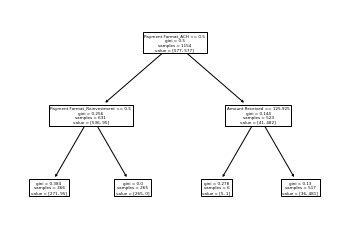

In [ ]:
##Plotting out decision tree - auprc
dt = DecisionTreeClassifier(max_depth = 2,min_samples_split = 2, class_weight = "balanced",criterion="gini",random_state=13)
dt.fit(X_trainval, y_trainval)
tree.plot_tree(dt,feature_names=x.columns)
plt.savefig('Decision Tree.png',format='png',bbox_inches = "tight",dpi=1000)